<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других.

**Цель работы**

Разработать инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Требования**

Модель со значением метрики качества *F1* не меньше 0.75.

`F1-score` — это метрика качества для двоичных и многоклассовых классификационных задач.\
Она представляет собой баланс между точностью и Recall, рассчитывается по формуле:

`F1 = 2 * (precision * recall) / (precision + recall)`

Эта метрика является более подходящей, чем точность, при неравномерном распределении классов.

**Описание данных**

Данные находятся в файле `/datasets/toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**План выполнения проекта**

1. Загрузим и подготовим данные.
2. Обучим разные модели отберем лучшую по целевому параметру. 
3. Сделаем выводы.

## Подготовка

### 1.1. Обновление библиотеки

In [1]:
!pip install -U scikit-learn -q

### 1.2. Импотр библиотек

In [2]:
import os
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

try:
    import spacy
except:
    !pip install spacy -q
    import spacy

from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

### 1.3. Загрузка данных

In [3]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, usecols=[1, 2])
else:
    df = pd.read_csv(pth2, usecols=[1, 2])

display(df.head())
print('-----\nИнформация о таблице:\n')
df.info()
print(f'-----\nДубликатов в таблице: {df.duplicated().sum()}')

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


-----
Информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
-----
Дубликатов в таблице: 0


### 1.4. Токенизация, удаление стоп-слов, лематизация, удаление строк разделителей

In [4]:
%%time

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords_english = set(stopwords.words('english'))
nltk.download('averaged_perceptron_tagger')

def f_preparation(text):
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = nltk.word_tokenize(text)
    text = ' '.join(text)
    return text

df['lemmatize_text'] = df['text'].apply(f_preparation)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Даниил\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Даниил\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Даниил\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Даниил\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


CPU times: total: 39.6 s
Wall time: 42.7 s


,text,toxic,lemmatize_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


In [5]:
%%time

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def f_lemmatize_sent(text): 
    text = [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(nltk.word_tokenize(text))]
    text = [word for word in text if word not in stopwords_english]
    return ' '.join(text)
     
df['lemmatize_text'] = df['lemmatize_text'].apply(f_lemmatize_sent)
df.head()

CPU times: total: 10min 39s
Wall time: 12min 50s


,text,toxic,lemmatize_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stick th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


In [6]:
def f_conti_rep_char(str1):
    tchr = str1.group(0)
    if len(tchr) > 1:
      return tchr[0:1]

def f_check_unique_char(rep, sent_text):
    convert = re.sub(r'(\w)\1+', rep, sent_text)
    return convert
 
df['lemmatize_text'] = df['lemmatize_text'].apply(lambda x : f_check_unique_char(f_conti_rep_char, x))
df

,text,toxic,lemmatize_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aw match background colour semingly stick than...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man realy try edit war guy constantly remo...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real sugestion improvement wonder section...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,second time ask view completely contradict cov...
159288,You should be ashamed of yourself \n\nThat is ...,0,ashamed horible thing put talk page
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer um theres actual article prostitution ...
159290,And it looks like it was actually you who put ...,0,lok like actualy put spedy first version delet...


### 1.5. Проверка разделения по классам

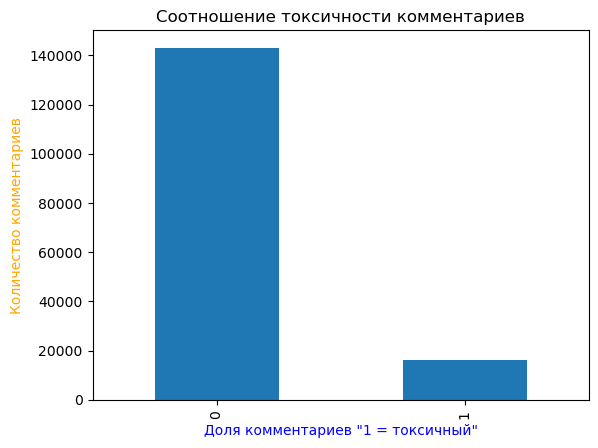

In [7]:
df['toxic'].value_counts().plot.bar()
plt.title('Соотношение токсичности комментариев')
plt.xlabel('Доля комментариев "1 = токсичный"', fontsize=10, color='blue')
plt.ylabel("Количество комментариев", fontsize=10, color='orange')
plt.show();

#### Вывод по загрузке и подготовке данных

- проведен импотр библиотек
- прочитаны необходимые данные
- проведена подготовка данных
    - данные приведены к нижнему регистру
    - оставлен только буквенный текст
    - проведена токенизация
    - проведена лематизация слов
    - убраны стоп-слова
- проведен анализ распределения токсичности по классам

## Обучение

### 2.1. Разделение на обучающую и тестовую выборки

Для отбора лучшей модели сократим выборку.

In [8]:
data = df.sample(n=10000, random_state=42).copy()

In [9]:
RANDOM_STATE = 42
vectorizer = TfidfVectorizer()

X = data['lemmatize_text']
y = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify = y)
round(X_train.shape[0]/X.shape[0], 2), round(X_test.shape[0]/X.shape[0], 2)

(0.8, 0.2)

### 2.2. Создание общего `Pipeline`

In [10]:
def f_training(model, params):
    pipeline = Pipeline([
        ('vect', TfidfVectorizer()),
        ('model', model)])
    grid = GridSearchCV(pipeline, cv = 5, n_jobs = -1, param_grid = params ,scoring = 'f1', verbose = False)
    grid.fit(X_train, y_train)
    print(f'Значение "F1-score" на кросс-валидации: {grid.best_score_:.3}\n----------')
    print(f'Параметры лучшей модели: {grid.best_params_}\n----------')
    return grid

### 2.3. Обучение `LogisticRegression()`

In [11]:
%%time
lr_mod = f_training(LogisticRegression(random_state=RANDOM_STATE), 
                    {
                     'model__C':[0.1, 1.0, 10.0], 
                     'model__penalty':["l1", "l2", "elasticnet", None]
                    }
)

Значение "F1-score" на кросс-валидации: 0.709
----------
Параметры лучшей модели: {'model__C': 0.1, 'model__penalty': None}
----------
CPU times: total: 1.09 s
Wall time: 8.04 s


### 2.4. Обучение `SVC`

In [12]:
%%time
svc_mod = f_training(SVC(kernel='linear', 
                     random_state=RANDOM_STATE),
                     {
                      'model__degree':[3, 4]
                     }
)

Значение "F1-score" на кросс-валидации: 0.636
----------
Параметры лучшей модели: {'model__degree': 3}
----------
CPU times: total: 4.75 s
Wall time: 15.6 s


### 2.5. Обучение `LGBMClassifier()`

In [13]:
%%time
lgbm_mod = f_training(LGBMClassifier(learning_rate=0.1, 
                                     n_estimators=200, 
                                     random_state=RANDOM_STATE,
                                     n_jobs=1,
                                     verbose=-1), 
                                     {
                                      'model__max_depth': [None, 8]
                                     }
)

Значение "F1-score" на кросс-валидации: 0.62
----------
Параметры лучшей модели: {'model__max_depth': 8}
----------
CPU times: total: 1.94 s
Wall time: 10.7 s


### 2.6. Обучение `DecisionTreeClassifier()`

In [14]:
%%time
dtc_mod = f_training(DecisionTreeClassifier(criterion='gini', random_state=RANDOM_STATE),
                     {
                      'model__max_depth':[None, 2,4,8]
                     }
)

Значение "F1-score" на кросс-валидации: 0.641
----------
Параметры лучшей модели: {'model__max_depth': None}
----------
CPU times: total: 6.75 s
Wall time: 14.2 s


### 2.7. Составление сводной таблицы по обученным моделям

Отбор модели с максимальным значением `F1-score` на валидационной выборке

In [15]:
results = pd.DataFrame({'Model': ['LogisticRegression', 'SVC', 'DecisionTreeClassifier', 'LGBMClassifier'],
                        'f1_score': [lr_mod.best_score_, svc_mod.best_score_, dtc_mod.best_score_, lgbm_mod.best_score_]
                      })
results = results.sort_values('f1_score', ascending=False).reset_index(drop=True).head(1)
results

,Model,f1_score
0,LogisticRegression,0.709475


### 2.8. Переобучение выбранной модели на полных данных

In [16]:
X = df['lemmatize_text']
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify = y)
round(X_train.shape[0]/X.shape[0], 2), round(X_test.shape[0]/X.shape[0], 2)

(0.8, 0.2)

In [17]:
%%time
lr_mod = f_training(LogisticRegression(random_state=RANDOM_STATE), 
                    {
                     'model__C':[0.1, 1.0, 10.0], 
                     'model__penalty':["l1", "l2", "elasticnet", None]
                    }
)

Значение "F1-score" на кросс-валидации: 0.774
----------
Параметры лучшей модели: {'model__C': 10.0, 'model__penalty': 'l2'}
----------
CPU times: total: 19.7 s
Wall time: 1min 17s


### 2.9. Расчет `F1-score` на тестовой выборке

По условию задачи её значение должно быть не меньше 0,75.

In [18]:
print(f'Метрика F1-score "LogisticRegression" на тестовой выборке: {lr_mod.score(X_test, y_test):.3f}')

Метрика F1-score "LogisticRegression" на тестовой выборке: 0.772


### 2.10. Проверка лучшей модели на адекватность моделью `DummyClassifier`

In [19]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE).fit(X_train, y_train)

print(f'Метрика F1-score "DummyClassifier" на тестовой выборке: {f1_score(y_test, dummy_clf.predict(X_test)):.3f}')
print(f'Значение F1-score "LogisticRegression" на тестовой выборке лучше "DummyClassifier" в: {lr_mod.score(X_test, y_test) / f1_score(y_test, dummy_clf.predict(X_test)) :.3f} раз')

Метрика F1-score "DummyClassifier" на тестовой выборке: 0.097
Значение F1-score "LogisticRegression" на тестовой выборке лучше "DummyClassifier" в: 7.937 раз


#### Вывод по обучению моделей

Результат тестирования нашей модели на тествой выборке лучше, чем результат константной модели. Метрика F1-score на тестовой выборке 0.772.

## Выводы

В процессе выполнения работы:
- Проведена подготовка данных
    - проведен импотр библиотек
    - прочитаны необходимые данные
    - проведена подготовка данных
        - данные приведены к нижнему регистру
        - оставлен только буквенный текст
        - проведена токенизация
        - проведена лематизация слов
        - убраны стоп-слова
    - проведен анализ распределения токсичности по классам
- Проведено разбиение данных на обучающую и тестовую выборку, для ускорения поиска лучшей модели, количестово строк случайным выбором сокращено до 10000
- Проведено обучение следующих моделей:
    - `LogisticRegression`
    - `SVC`
    - `LGBMClassifier`
    - `DecisionTreeClassifier`
- По показателю F1-score отобрана лучшая модель - `LogisticRegression`
- Выбранная модель переобучена на полном наборе обучающей выборки, получены следующие значения:
    - Метрика F1-score "LogisticRegression" на кросс-валидации: 0.77  > 0.75
    - Метрика F1-score "LogisticRegression" на тестовой выборке: 0.77 > 0.75
- Проведено сравнение расчитанных метрик с целевым значением метрики качества F1-score (не меньше 0.75)
- Лучшую модель проверена на адекватность моделью `DummyClassifier`


- *Результат:
Для интернет-магазин «Викишоп» разработан инструмент, который будет искать токсичные комментарии и отправлять их на модерацию, при этом значение качества модели превышает установленный минимальный уровень в 0.75*